## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [1]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def benchmark(steer_function: str, settings: [dict]):
    pool = MultipleMPB()
    for setting in settings:
        m = MPB()
        m.update(setting)
        m.set_steer_functions([steer_function])
        m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
        pool.benchmarks.append(m)

### Moving AI Scenarios

In [38]:
scenario = 'Berlin_0_256.map.scen'
num_scenarios = 10
steer_function = 'reeds_shepp'

scenario_file = '/home/eric/mpb/bin/moving_ai_scenarios/%s' % scenario

config = MPB.get_config()
config["benchmark.moving_ai.active"] = True
pool = MultipleMPB()
for i in range(num_scenarios):
    m = MPB()
    config["benchmark.moving_ai.start"] = i - num_scenarios
    config["benchmark.moving_ai.end"] = i - num_scenarios
    config["benchmark.moving_ai.scenario"] = scenario_file
    config["max_planning_time"] = 15
    #     config["env.collision.collision_model"] = 0
    m.update(deepcopy(config))
    m.set_steer_functions([steer_function])
    #     m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
    m.set_planners(['theta_star'])
    pool.benchmarks.append(m)
pool.run_parallel("moving_ai_%s" % steer_function)

Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Selected steer functions: ['reeds_shepp']
Selected planners: ['theta_star']
Available memory: 21.62 GB, limiting each MPB process to 41.7% usage.
Creating pool of 12 processes.
Running MPB with ID moving_ai_reeds_shepp_3 (log file at moving_ai_reeds_shepp/moving_ai_reeds_shepp_3.log)...
Running MPB with ID moving_a




Benchmark 8 (moving_ai_reeds_shepp_8) finished successfully.
Benchmark 2 (moving_ai_reeds_shepp_2) finished successfully.



Benchmark 6 (moving_ai_reeds_shepp_6) finished successfully.
Benchmark 5 (moving_ai_reeds_shepp_5) finished successfully.

Benchmark 0 (moving_ai_reeds_shepp_0) finished successfully.

Benchmark 4 (moving_ai_reeds_shepp_4) finished successfully.

Benchmark 3 (moving_ai_reeds_shepp_3) finished successfully.



Benchmark 9 (moving_ai_reeds_shepp_9) failed. Return code: -11.


Benchmark 1 (moving_ai_reeds_shepp_1) failed. Return code: -11.


Benchmark 7 (moving_ai_reeds_shepp_7) failed. Return code: -11.
Error(s) occurred, not all benchmarks succeeded.
Benchmark 1 failed with return code -11. See log file moving_ai_reeds_shepp/moving_ai_reeds_shepp_1.log.
Benchmark 7 failed with return code -11. See log file moving_ai_reeds_shepp/moving_ai_reeds_shepp_7.log.
Benchmark 9 failed with return code -11. See log file moving_ai_reeds_shepp/moving_ai_reeds_shepp_9.log.


False

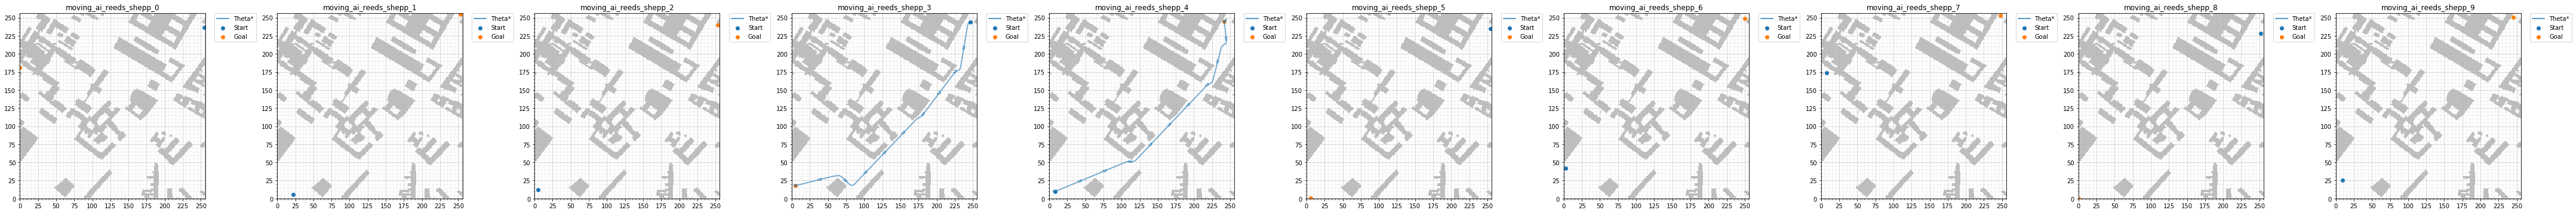

In [39]:
pool.visualize_trajectories(show_legend=True)
plt.savefig("test.pdf")

Successfully merged [moving_ai_reeds_shepp/moving_ai_reeds_shepp_0_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_1_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_2_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_3_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_4_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_5_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_6_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_7_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_8_results.json, moving_ai_reeds_shepp/moving_ai_reeds_shepp_9_results.json] into moving_ai_reeds_shepp/total.json.
Visualizing moving_ai_reeds_shepp/total.json...


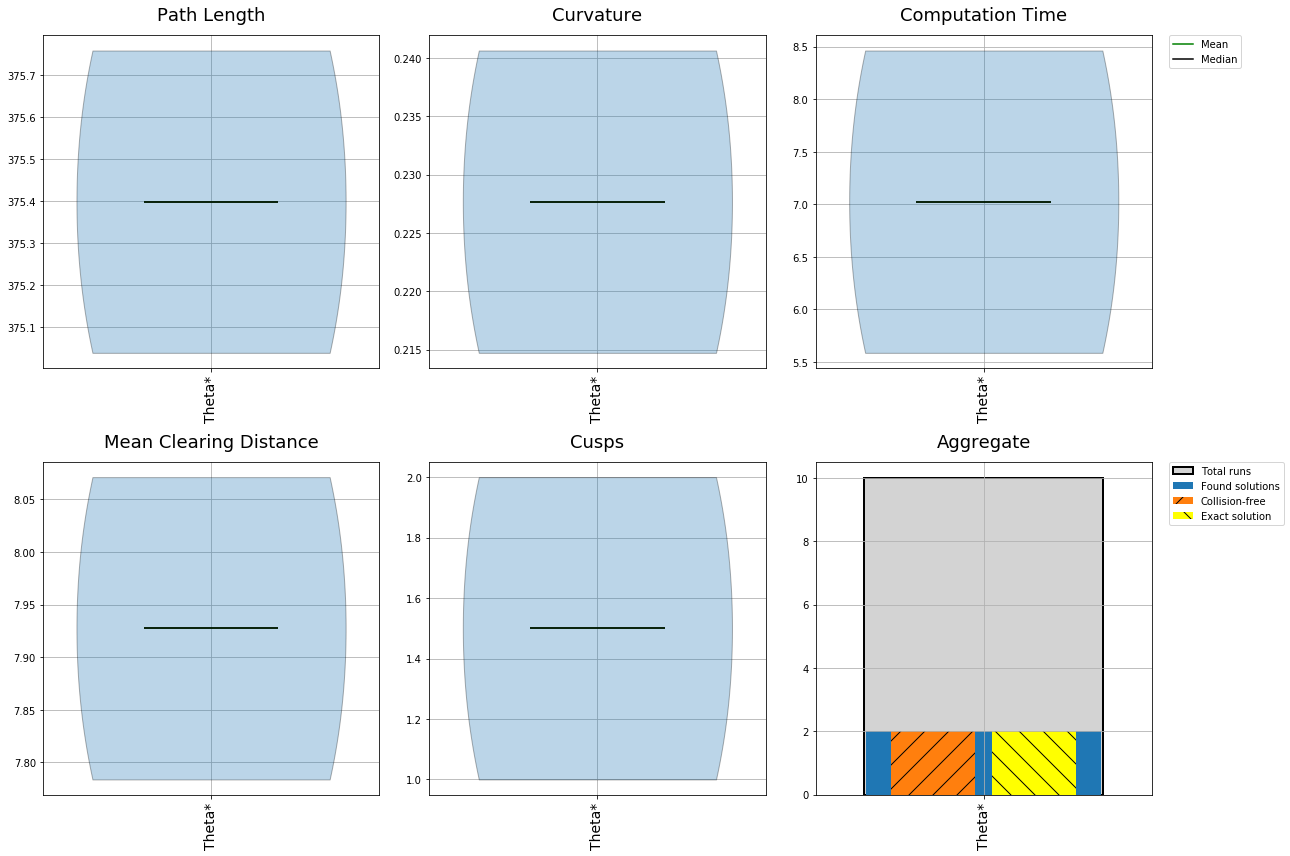

In [40]:
MPB.merge(pool.benchmarks, "moving_ai_%s/total.json" % steer_function, make_separate_runs=True)
from plot_stats import plot_planner_stats
plot_planner_stats("moving_ai_%s/total.json" % steer_function)